In [2]:
from climada.util.api_client import Client
from climada_petals.engine import SupplyChain
from climada.entity import ImpfSetTropCyclone, ImpactFuncSet
from climada.engine.impact_calc import ImpactCalc
from climada.hazard import Hazard
import datetime
import numpy as np
client = Client()

In [3]:
# we get probabilistic tc for WP and NA
tc_wp_prob = client.get_hazard('tropical_cyclone', name='tropical_cyclone_10synth_tracks_150arcsec_genesis_WP_1980_2020')
tc_na_prob = client.get_hazard('tropical_cyclone', name='tropical_cyclone_10synth_tracks_150arcsec_genesis_NA_1980_2020')

https://climada.ethz.ch/data-api/v1/dataset	data_type=tropical_cyclone	limit=100000	name=tropical_cyclone_10synth_tracks_150arcsec_genesis_WP_1980_2020	status=active	version=None
https://climada.ethz.ch/data-api/v1/dataset	data_type=tropical_cyclone	limit=100000	name=tropical_cyclone_10synth_tracks_150arcsec_genesis_NA_1980_2020	status=active	version=None


In [4]:
assets = client.get_litpop()

https://climada.ethz.ch/data-api/v1/dataset	data_type=litpop	exponents=(1,1)	limit=100000	name=None	spatial_coverage=global	status=active	version=None


/Users/szelie/miniconda3/envs/climada_boario_env/lib/python3.9/pickle.py:1717: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


In [5]:
def get_impf_id(cnt):
    for basin, iso_list in ImpfSetTropCyclone.get_countries_per_region()[2].items():
        for iso in iso_list:
            if iso == cnt:
                return basin, ImpfSetTropCyclone.get_countries_per_region()[1][basin]
            
impf_TC = ImpfSetTropCyclone.from_calibrated_regional_ImpfSet()

assets.gdf['impf_TC'] = 1

for cnt in np.unique(assets.gdf.region_id):
    assets.gdf.loc[assets.gdf['region_id']==cnt, 'impf_TC'] = get_impf_id(int(cnt))[1]

# impact calculation, already selecting the date
imp_calc = ImpactCalc(assets, impf_TC, tc_na_prob)
direct_impact_na = imp_calc.impact(save_mat=True)  

imp_calc = ImpactCalc(assets, impf_TC, tc_wp_prob)
direct_impact_wp = imp_calc.impact(save_mat=True) 

2023-05-26 17:46:52,969 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 6368468 coordinates.
2023-05-26 17:47:14,627 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 7549716 coordinates.
2023-05-26 17:47:15,017 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 7249 coordinates.


In [43]:
from climada.util import yearsets
def make_yearset(impact_dict, n_years):
    """
    Parameters
    ----------
    impact_dict : dict of Impact
        dictionary of impacts
    n_years : number of years

    Returns
    -------
    imp : dict
        
    """
    years = np.arange(1, n_years+1)
    yearset_dict = {}
    for impact in impact_dict:
        lam = np.sum(impact_dict[impact].frequency)
        lam = np.round(lam, 10)
        events_per_year = yearsets.sample_from_poisson(len(years), lam)
        sampling_vect = yearsets.sample_events(events_per_year, impact_dict[impact].frequency)
        yearset = yearsets.impact_from_sample(impact_dict[impact], years, sampling_vect)
        yearset_dict[impact] = yearset
    return yearset_dict

In [45]:
def set_imp_mat(impact, imp_mat):
    """
    Set Impact attributes from the impact matrix. Returns a copy.
    Overwrites eai_exp, at_event, aai_agg, imp_mat

    Parameters
    ----------
    impact: Impact
    imp_mat : sparse.csr_matrix
        matrix num_events x num_exp with impacts.
    Returns
    -------
    imp : Impact
        Copy of impact with eai_exp, at_event, aai_agg, imp_mat set.
    """
    imp = copy.deepcopy(impact)
    imp.at_event, imp.eai_exp, imp.aai_agg = ImpactCalc.risk_metrics(imp_mat, imp.frequency)
    imp.imp_mat = imp_mat
    return imp


In [40]:
from climada.util import yearsets, coordinates

import pycountry

# create n years of impacts by sampling events based on the expected number of events. This is
# done per basin
def yearset_impact(direct_impact_wp, direct_impact_na, countries_num, n_years):
    
    impact_dict = {'wp':direct_impact_wp, 'na':direct_impact_na}
    ys = make_yearset(impact_dict, n_years)
    imp_mat = sparse.vstack([ys['wp'].imp_mat,ys['na'].imp_mat])
    imp = Impact()
    imp.frequency = np.hstack([ys['wp'].frequency, ys['na'].frequency])
    imp.date = np.hstack([ys['wp'].date, ys['na'].date])
    imp.event_id = np.hstack([ys['wp'].event_id, (ys['na'].event_id+np.max(ys['wp'].event_id))])
    imp = set_imp_mat(imp, imp_mat)
    imp.coord_exp = direct_impact_wp.coord_exp
    imp = imp.select(event_ids = imp.event_id[imp.at_event>1e8])
    country_matrices = {country: np.array([imp.imp_mat[:, countries_num == countries[country]].sum(axis=1).flatten()])
                    for country in countries}
    
    years = [datetime.date.fromordinal(date).year for date in imp.date]
    country_year_impact = {year: {country: country_matrices[country][0][0][years==year].sum()\
                              for country in countries} for year in np.unique(years)}
  
    n_countries_per_year = {year:np.sum([np.array(list(country_year_impact[year].values()))>1e8]) for year in years}
    

    return (imp, country_year_impact, n_countries_per_year, imp.aai_agg)



In [ ]:
from climada.util import yearsets, coordinates
lat = np.array([lat for lat,lon in direct_impact_wp.coord_exp])
lon = np.array([lon for lat,lon in direct_impact_wp.coord_exp])
countries_num = coordinates.get_country_code(lat, lon)
countries_num = np.array([format(num, '03d') for num in countries_num])


In [47]:
from scipy import sparse
from climada.engine import Impact
import copy
countries = ['USA', 'TWN', 'JPN','CHN','MEX'] # we could chose more countries
countries = {country:pycountry.countries.lookup(country).numeric for country in countries}

# 100 time 5 years, date start at year 1
yearsets_samples = [yearset_impact(direct_impact_wp, direct_impact_na, countries_num) for n in range(0,100)]

In [48]:
n_countries_score = [np.sum(list(yearsets_samples[n][2].values())) for n in range(len(yearsets_samples))]

aai = [yearsets_samples[n][3] for n in range(len(yearsets_samples))]

In [49]:
np.argsort(n_countries_score) # if we want to sort by number of countries affected

array([44, 80, 33, 91, 27, 13,  6, 42, 68, 43, 77,  0,  4, 97, 48, 36, 89,
       85, 57, 51, 83, 66, 67, 69, 70, 72, 79, 45, 30, 39,  7, 29, 23,  5,
       18, 93, 84, 92, 56, 53, 52, 65, 16,  8, 46, 54, 71, 40, 38, 87, 88,
       25, 26, 61, 73, 11, 95, 64, 75, 81,  1, 82, 28, 15, 50, 47, 20, 90,
       60, 55, 98, 94,  9, 17, 19, 41, 21, 32, 78, 49, 74,  2, 10, 12, 24,
       34, 35, 31, 37, 59, 62, 76,  3, 96, 58, 22, 63, 86, 99, 14])

In [26]:
np.argsort(aai)

array([17, 57, 43, 22,  3, 89, 16, 61, 68, 11, 53, 20, 15, 23, 13, 59, 73,
       42, 25, 66, 74, 10, 26, 90, 56, 60, 33, 86, 12,  7, 41, 92, 75, 81,
       29, 30, 55, 49, 64, 46, 45, 62,  9, 98, 38, 87, 35, 83, 84, 95, 27,
        4,  2,  8,  0, 82, 24, 78, 37, 54, 80, 39, 40, 79, 31,  6, 32, 94,
       99, 72, 63, 50,  1, 47, 67, 71, 52, 34, 97, 91, 14, 36, 85, 21, 76,
       93, 69, 18, 58, 44, 48, 70, 28, 65, 77, 51, 96,  5, 88, 19])

In [79]:
#5 years with most damages:
picked_yearset1 = yearsets_samples[np.argsort(aai)[0]][0]
picked_yearset1.tag = direct_impact_wp.tag #we miss the tag if we want to save it

#5 years with most countries affected:

picked_yearset2 = yearsets_samples[np.argsort(n_countries_score)[0]][0]
picked_yearset2.tag = direct_impact_wp.tag #we miss the tag if we want to save it
#yearsets_samples[17][0].write_csv("yearset_wp_na_combined.csv") #to save

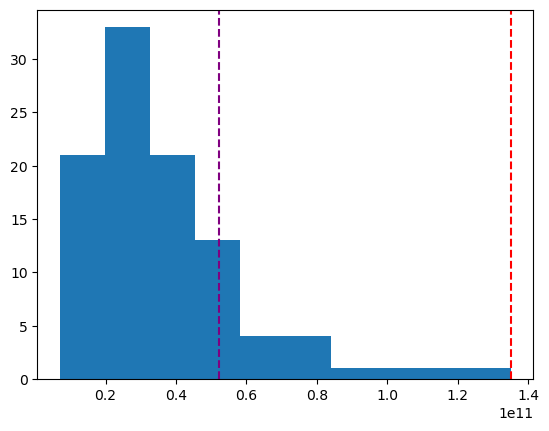

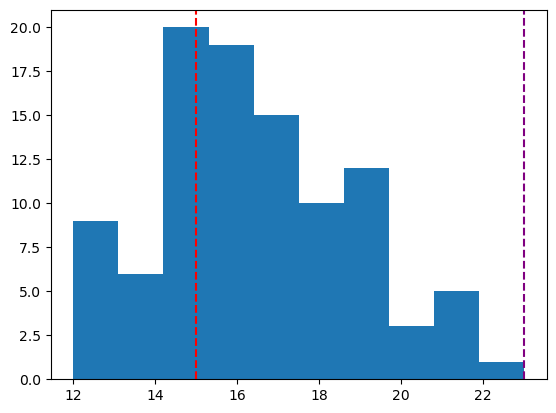

In [78]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.hist(aai)
plt.axvline(x=np.max(aai), color='red', linestyle='--')# yearset with most total damage

plt.axvline(x=aai[np.argsort(n_countries_score)[0]], color='purple', linestyle='--') # yearset with most countries affected

fig,ax = plt.subplots()

ax.hist(n_countries_score)
plt.axvline(x=n_countries_score[np.argsort(aai)[0]], color='red', linestyle='--') 
plt.axvline(x=np.max(n_countries_score), color='purple', linestyle='--')# yearset with most total damage
